In [78]:
import time
import pandas as pd
import seaborn as sns
import pandahouse
from scipy.stats import ttest_ind
from scipy.stats import shapiro

<b>Задание часть 1</b>

Итак, что нужно сделать: у нас есть данные А/А-теста с '2023-07-23' по '2023-07-29'. Вам нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.

4. Пришлите ссылку на merge request c проведенным анализом.

---------------

<h4>
Для начала выгружаем данные из базы (подсчет CTR сделаем при выгрузке)
    
Рассмотрим данные подробнее и проведем АА тест на полных группах 2 и 3
</h4>

In [26]:
# Соединение с базой

connection = {
    'host': 'https://clickhouse',
    'password': 'pass',
    'user': 'user',
    'database': 'db'
}

q = '''
SELECT 
user_id,
exp_group,
countIf(action, action='like')/countIf(action, action='view') as CTR

FROM simulator_20230820.feed_actions 
WHERE 
toDate(time) >= '2023-07-23' and toDate(time) <= '2023-07-29'
AND
exp_group in (2, 3)
GROUP BY
user_id, exp_group
'''

df_users = pandahouse.read_clickhouse(q, connection=connection) 

In [27]:
# Смотрим что загрузили
df_users.head()

,user_id,exp_group,CTR
0,115383,3,0.153226
1,10326,3,0.181818
2,123580,3,0.204918
3,131473,2,0.193878
4,23985,2,0.272727


In [28]:
# Смотрим на точечные оценки 2 исследуемых групп
df_users[df_users['exp_group'] == 2].describe()

,user_id,exp_group,CTR
count,8362.000000,8362.0,8362.000000
mean,70165.438531,2.0,0.220207
std,53364.413044,0.0,0.083804
min,220.000000,2.0,0.000000
25%,16024.000000,2.0,0.166667
50%,107968.000000,2.0,0.206522
75%,121473.750000,2.0,0.260870
max,133392.000000,2.0,0.700000


In [29]:
df_users[df_users['exp_group'] == 3].describe()

,user_id,exp_group,CTR
count,8425.000000,8425.0,8425.000000
mean,70922.573412,3.0,0.219357
std,53138.044904,0.0,0.082558
min,215.000000,3.0,0.000000
25%,16332.000000,3.0,0.166667
50%,108455.000000,3.0,0.207317
75%,121478.000000,3.0,0.260870
max,133388.000000,3.0,0.769231


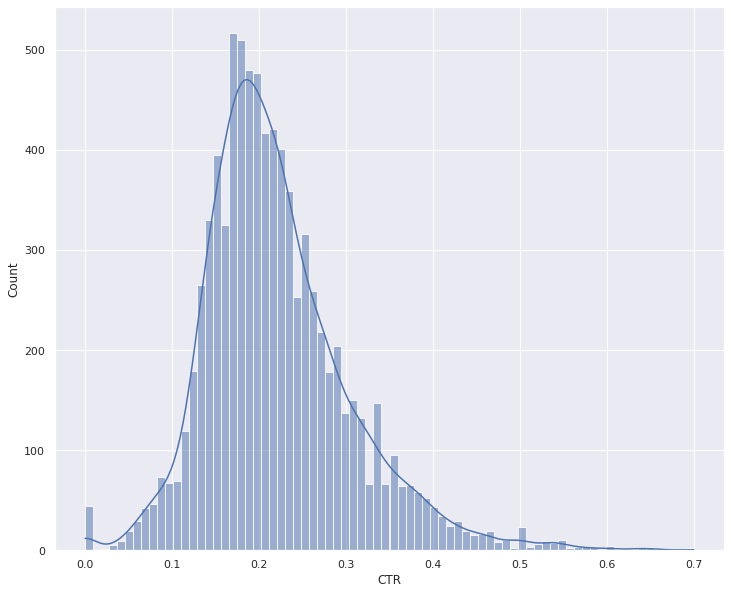

In [30]:
# Визуализируем распределение частот 2 групп
sns.set (rc={"figure.figsize":( 12 , 10 )})
group_2 = sns.histplot(df_users[df_users['exp_group'] == 2]['CTR'], kde=True)

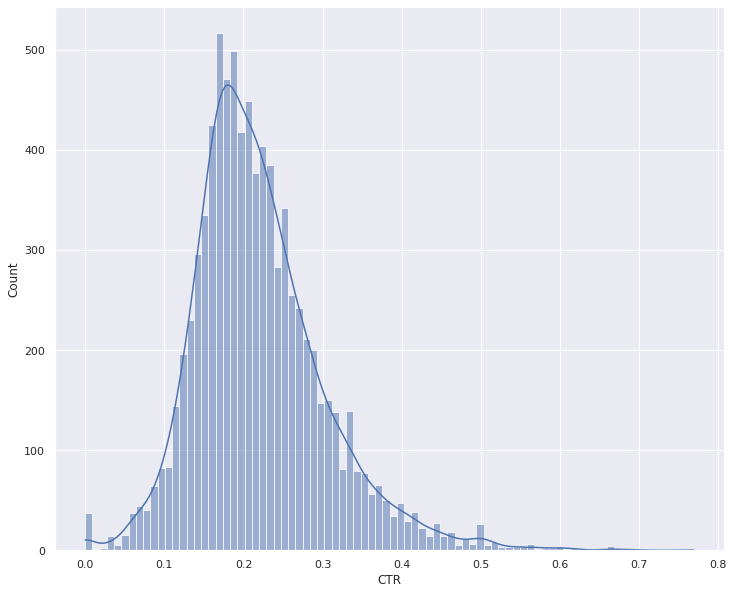

In [31]:
group_3 = sns.histplot(df_users[df_users['exp_group'] == 3]['CTR'], kde=True)

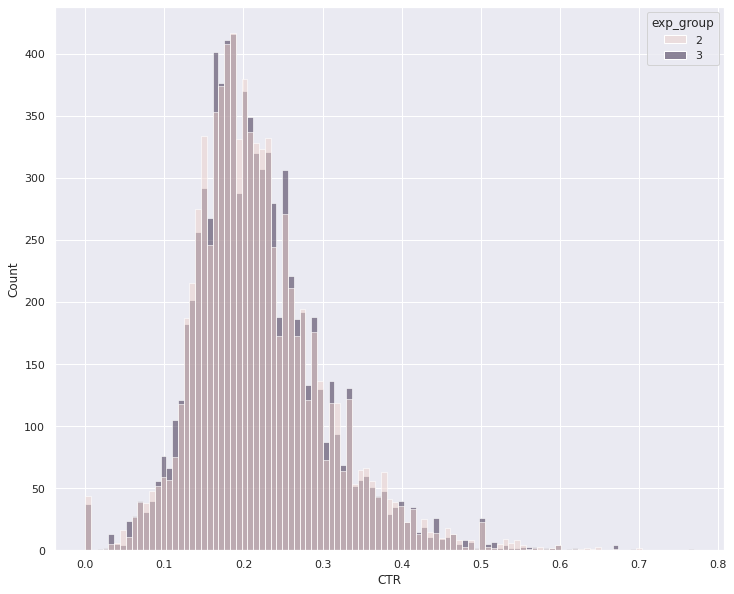

In [32]:
groups = sns.histplot(data = df_users, x = 'CTR', hue='exp_group')

Предварительные выводы на основе визуального анализа:

   > - 2 группы различаются средними значениями из-за наличия выбросов
   > - Оба распределения смещены к нулю (положительное смщение - среднее больше моды)
    
<b>Замечание: Распределение похоже на нормальное по форме Т-тест обычно корректно отрабатывает на таких выборках не смотря на то, что тест на нормальность прокрашивается</b>

In [35]:
# Для наглядности запустим тест шапиро-уилка
shapiro(df_users[df_users['exp_group'] == 3]['CTR']), shapiro(df_users[df_users['exp_group'] == 2]['CTR'])


(ShapiroResult(statistic=0.9518260359764099, pvalue=0.0),
 ShapiroResult(statistic=0.9473466873168945, pvalue=0.0))

Тест на нормальность прокрасился - такое часто бывает с большим набором данных, чем больше выборка тем реже она будет соответствовать формальным кретериям нормальности

In [8]:
# Сохраним отдельно серии из датафрейма
ctr_3 = df_users[df_users['exp_group'] == 3]['CTR']
ctr_2 = df_users[df_users['exp_group'] == 2]['CTR']

In [15]:
# Проводим Т-тест, Нульевая гипотеза = о равенстве средних значения

base_test = ttest_ind(ctr_2, ctr_3, equal_var=False)
base_test

Ttest_indResult(statistic=0.6617303509169986, pvalue=0.508153138292614)

<b>Т-тест говорит о том, что не найдено статистически знаимых различий между средними значениями групп 2 и 3</b>

Мы убедились, что подвоха в данных нет, и имеет смысл счиать Т-кретерий случайных выборок.

-----------------------

Вам нужно сделать симуляцию, как будто мы провели 10000 А/А-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.



In [58]:
# напишем класс-калькулятор для данного задания

class SimulatorAAtest():
    
    def __init__(self):
        self.results = []
    
    def __call__(self, groups:tuple, n=10000, n_users=500):
        group1, group2 = groups
        start_time = time.time()
        for _ in range(n):
            group1_sample = group1.sample(n_users)
            group2_sample = group2.sample(n_users)
            self.results.append(ttest_ind(group1_sample, group2_sample).pvalue)
        print(f'Проведено {n} АА тестов\nЗатрачено {round(time.time() - start_time, 2)} sec.')
        print('<object>.get_results() для получения результатов')
    
    def get_results(self):
        return pd.DataFrame(data = self.results, columns=['p-value'])

In [59]:
simulation1 = SimulatorAAtest()
simulation1((ctr_2, ctr_3))

Проведено 10000 АА тестов
Затрачено 15.82 sec.
<object>.get_results() для получения результатов


In [63]:
res = simulation1.get_results()
res.head()

,p-value
0,0.924386
1,0.543482
2,0.686407
3,0.768379
4,0.527988


In [64]:
res.describe()

,p-value
count,10000.000000
mean,0.506585
std,0.288325
min,0.000020
25%,0.257978
50%,0.511075
75%,0.754951
max,0.999965


----------

<b> Идем дальше по списку задач </b>
>Построить гистограмму распределения получившихся 10000 p-values.

>Посчитать, какой процент p values оказался меньше либо равен 0.05

>Написать вывод по проведенному А/А-тесту, корректно ли работает наша система сплитования.

>Пришлите ссылку на merge request c проведенным анализом.

<Axes: ylabel='Count'>

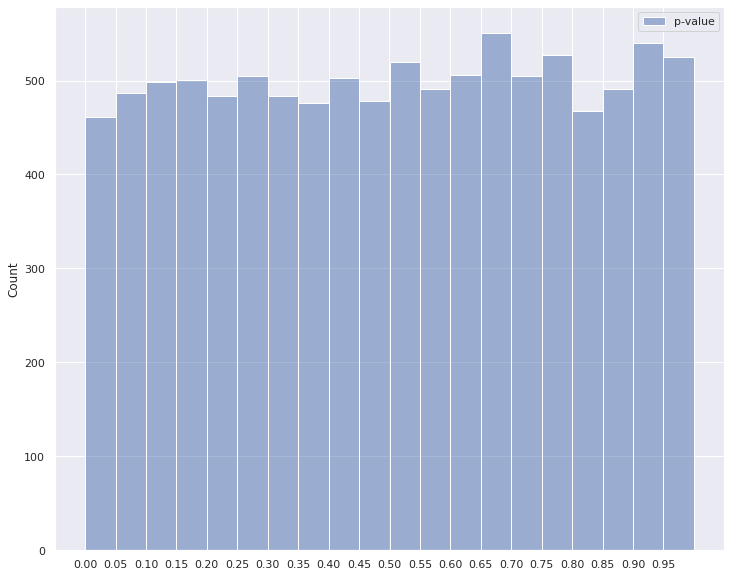

In [83]:
# Построить гистограмму распределения получившихся 10000 p-values.
plot = sns.histplot(res, binwidth=0.05)
plot.set_xticks([x/100 for x in range(0, 100, 5)])
plot

In [99]:
# Посчитать, какой процент p values оказался меньше либо равен 0.05

p_values_proc = res[res >= 0.05].isna().sum()/res.count()
p_values_proc = p_values_proc * 100

In [104]:

f'{p_values_proc.values[0]}% сгенерированных Т - тестов показало значимые различия при уровне значимости p-value = 0,05'

'4.61% сгенерированных Т - тестов показало значимые различия при уровне значимости p-value = 0,05'

> <b>Вывод: мы удостоверились в корректности работы системы сплитования. Заявленный уровень стат. значимости 0,05 подтверждается экспериментально при многократном моделировании повторения АА теста.</b>
